In [15]:
# zmiana szerokości konternera/komórek notebooka
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## **WYKORZYSTANIE WYNIKÓW GRUPOWANIA KLIENTÓW CENTRUM HANDLOWEGO DO OPRACOWANIA MODELU NADZOROWANEGO DLA INDYWIDUALNYCH OFERT HANDLOWYCH**

#### *Autorzy:*
`Mateusz Jęczarek,
Bartosz Marcinkowski,
Michał Oziębło`

#### *Opis problemu badawczego:*
`Zbiór danych zawiera podstawowe dane na temat klientów centrum handlowego.
Za pomocą uczenia nienadzorowanego metodą klastrowania K-średnich zostaną oni przypisani do pięciu klastrów. 
Klastry te następnie zostaną scharakteryzowane, a informacje te posłużą do napisania modelu nadzorowanego klasyfikacji, pozwalajacego na dopasowanie indywidualnych ofert handlowych zgodnych z preferencjami danego klienta.`

#### *Opis zbioru danych:*
`Informacje w zbiorze danych zawierają informacje o wieku, płci, rocznym dochodzie oraz miare popytu, zależną od deklarowanej w ankietach wartości zakupów podczas wizyty.`

`Źródło:`
https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python?fbclid=IwAR2wjzN4v4Ot8ESuNtKYfnGSPKjHQ7WwEe7LXGY0Ovlw6ahLbpi8iS4SWts#Mall_Customers.csv

#### *Algorytmy zastosowane w projekcie:*

*   `K-means clustering` (https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)
* `The Elbow method` (https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)
* `The Silhouette method` (https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)
* `Clustering with optimised weights for Gower's metric` (https://science.vu.nl/en/Images/stageverslag-hoven_tcm296-777817.pdf , https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/?fbclid=IwAR0yqFSWvHKOpuRfAoBXGX9bCHPe_kpkz1UFhxVOIfT-1hFg3XmT05ZvWq4)
*   `Decision Tree` (https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)
* `Random Forest` (https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

**TO DO: DODAĆ ZWIĘZŁY OPIS SŁOWNY (PO JEDNYM AKAPICIE) O KAŻDYM Z  ALGORYTMÓW**

###### Import pakietów, ustawienie ziarna losowania

In [16]:
# import pakietów wykorzystanych w projekcie:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import scipy
import random
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import copy
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import (linkage, 
                                     fcluster, 
                                     dendrogram)
!pip install gower
import gower

In [0]:
# ustawienie ziarna losowania:
random.seed(1)

###### Charakterystyka danych:

In [0]:
# import danych z pliku.csv do DataFrame:
dataset = pd.read_csv("https://raw.githubusercontent.com/ozieblo-repository/test/master/Mall_Customers.csv")

In [19]:
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [20]:
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Zaimportowany plik składa się z 5 kolumn, cztery zawierające dane ilościowe i jedną z daną jakościową (płeć):

*   `CustomerID` - indentyfikator klienta w bazie danych; zbiór zawiera 200 rekordów,
*   `Gender` - płeć klienta (Male/Female),
*   `Age` - wiek klienta,
*   `Annual Income (k$)` - roczny dochód klienta, w tysiącach dolarów rocznie,
*   `Spending Score (1-100)` - ustandaryzowana miara wydatków klientów, zależna od deklarowanej wartości zakupów podczas wizyty (maks. 100)



###### Analiza argumentów względem płci:

Algorytm klastrowania K-średnich oparty jest o dane ilościowe ciągłe **<ŹRÓDŁO?>**, z tej przyczyny nie grupujemy klientów z uwzględnieniem ich płci, a więc wobec zmiennej jakościowej/kategorycznej. Będzie to miało również korzystny wpływ na ograniczenie ilości grup klientów, jakie chcemy wyszczególnić. **<DLACZEGO?>**

Przyjrzyjmy się wobec tego, jaki jest rozkład płci naszych klientów , ich wieku oraz miary popytu względem płci.

**TO DO: POPRAWIĆ TEN TEKST**

In [21]:
# odczytanie proporcji kobiet i mężczyzn w zbiorze:
dataset['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

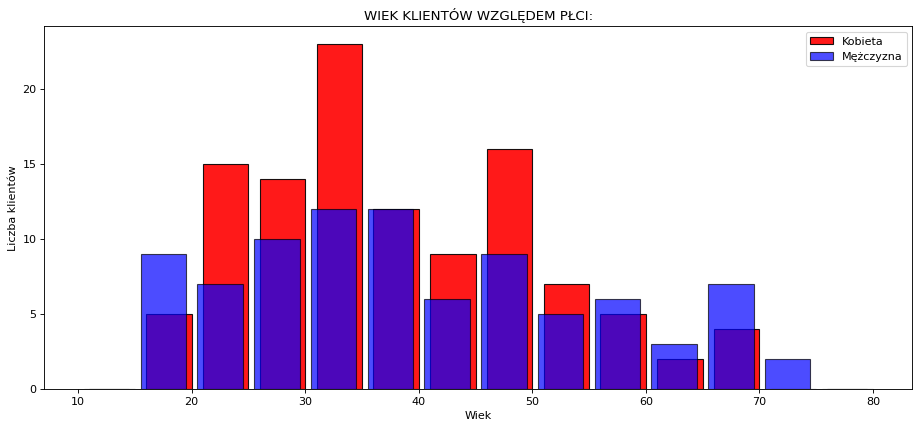

In [22]:
# histogram - liczba/wiek klientów względem płci:
bins = np.linspace(10, 80, 15)
shift = 0.5

figure(num=None, 
       figsize=(14, 6), 
       dpi=80, 
       facecolor='w', 
       edgecolor='k')

plt.hist('Age', 
         bins=bins+shift, 
         data=dataset[dataset['Gender'] == 'Female'], 
         color='red', 
         alpha=0.9, 
         label='Kobieta',
         histtype='bar',
         ec='black',
         rwidth=0.8)
plt.hist('Age', 
         bins=bins, 
         data=dataset[dataset['Gender'] == 'Male'], 
         color='blue', 
         alpha=0.7, 
         label='Mężczyzna',
         histtype='bar',
         ec='black',
         rwidth=0.8)
plt.title('WIEK KLIENTÓW WZGLĘDEM PŁCI:')
plt.xlabel('Wiek')
plt.ylabel('Liczba klientów')
plt.legend()

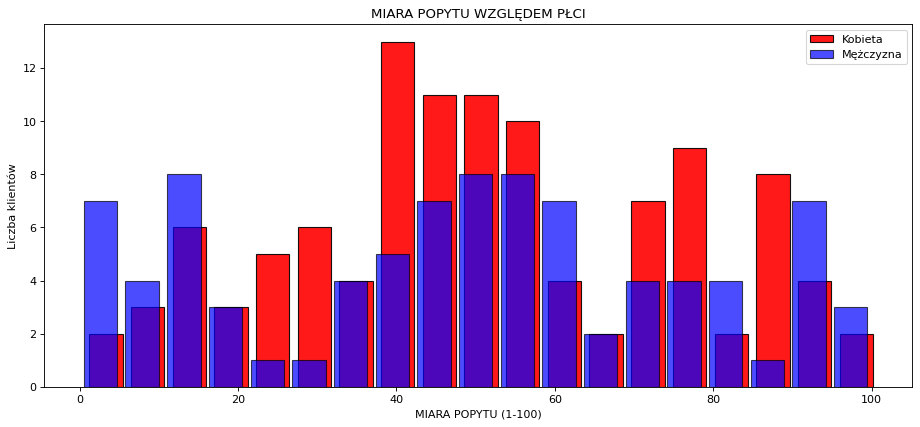

In [23]:
# histogram - liczba/miara popytu klientów względem płci:
bins = np.linspace(0, 100, 20)
shift=0.7

figure(num=None, 
       figsize=(14, 6), 
       dpi=80, 
       facecolor='w', 
       edgecolor='k')

plt.hist('Spending Score (1-100)',
         bins=bins+shift, 
         data=dataset[dataset['Gender'] == 'Female'], 
         color='red', 
         alpha=0.9, 
         label='Kobieta',
         histtype='bar',
         ec='black',
         rwidth=0.8)
plt.hist('Spending Score (1-100)', 
         bins=bins, 
         data=dataset[dataset['Gender'] == 'Male'], 
         color='blue', 
         alpha=0.7, 
         label='Mężczyzna',
         histtype='bar',
         ec='black',
         rwidth=0.8);
plt.title('MIARA POPYTU WZGLĘDEM PŁCI')
plt.xlabel('MIARA POPYTU (1-100)')
plt.ylabel('Liczba klientów')
plt.legend()

**<WNIOSEK CZąSTKOWY Z POWYŻSZEJ ANALIZY>**

#### *Selekcja zmiennych do klastrowania:*

In [0]:
df = dataset[['Age', 
              'Annual Income (k$)',
              'Spending Score (1-100)']]

#### *Estymacja optymalnej liczby klastrów:*

##### Elbow method:

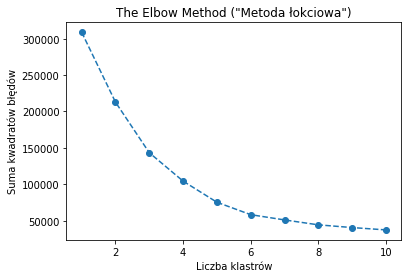

In [25]:
random.seed(1)

wb = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df)
    wb.append(kmeans.inertia_)

plt.plot(range(1, 11), 
         wb, 
         linestyle='--', 
         marker='o')
plt.title('The Elbow Method ("Metoda łokciowa")')
plt.xlabel('Liczba klastrów')
plt.ylabel('Suma kwadratów błędów')
plt.show()

##### The Silhouette Method:

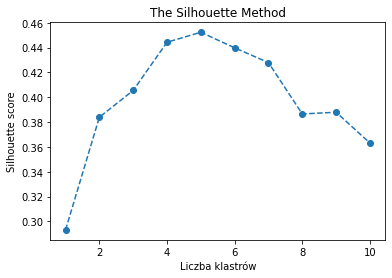

In [26]:
sil = []
kmax = 11

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df)
  labels = kmeans.labels_
  sil.append(silhouette_score(df, labels, metric = 'euclidean'))

plt.plot(range(1, 11), 
         sil, 
         linestyle='--', 
         marker='o')
plt.title('The Silhouette Method')
plt.xlabel('Liczba klastrów')
plt.ylabel('Silhouette score')
plt.show()

#The Silhouette Score reaches its global maximum at the optimal k

**<WNIOSEK CZąSTKOWY Z POWYŻSZEJ ANALIZY>**

#### *Parametryzacja modelu:*

In [0]:
random.seed(1)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
km_pred = kmeans.predict(df)

In [30]:
df_copy = copy.copy(df)
df_copy['Cluster'] = [str(i) for i in km_pred]
df_copy

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,2
1,21,15,81,1
2,20,16,6,2
3,23,16,77,1
4,31,17,40,2
...,...,...,...,...
195,35,120,79,3
196,45,126,28,0
197,32,126,74,3
198,32,137,18,0


#### *Wykres dla modelu:*

In [35]:
wykres_kmean = px.scatter_3d(df_copy, 
                    x='Age', 
                    y='Annual Income (k$)', 
                    z='Spending Score (1-100)', 
                    color='Cluster') 
wykres_kmean.show()

In [0]:
# zapis wyników do zmiennej wyniki_przed_norm w celu późniejszego porównania względem wyników po normalizacji danych:
wyniki_przed_norm = df_copy['Cluster']

# Normalizacja danych dla modelu

K-means clustering is "isotropic" in all directions of space and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering

> wstępny wniosek jest taki, że tutaj jest to zbędne, a wręcz szkodliwe

In [37]:
df_norm = copy.copy(df)
df_norm.columns = [0,1,2]

for i in range(3):
  df_norm[i] = [n/np.std(df_norm[i]) for n in df_norm[i]]

df_norm.columns = ['Age(Norm.)',
                   'Annual_Income(Norm.)',
                   'Spending_Score(Norm.)']
df_norm

,Age(Norm.),Annual_Income(Norm.),Spending_Score(Norm.)
0,1.363567,0.572541,1.514041
1,1.507100,0.572541,3.144546
2,1.435334,0.610711,0.232929
3,1.650634,0.610711,2.989260
4,2.224767,0.648880,1.552862
...,...,...,...
195,2.511834,4.580332,3.066903
196,3.229501,4.809348,1.087004
197,2.296534,4.809348,2.872795
198,2.296534,5.229212,0.698788


In [38]:
random.seed(1)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_norm)
km_pred = kmeans.predict(df_norm)

df_norm['Cluster'] = [str(i) for i in km_pred]
df_norm

,Age(Norm.),Annual_Income(Norm.),Spending_Score(Norm.),Cluster
0,1.363567,0.572541,1.514041,0
1,1.507100,0.572541,3.144546,0
2,1.435334,0.610711,0.232929,4
3,1.650634,0.610711,2.989260,0
4,2.224767,0.648880,1.552862,0
...,...,...,...,...
195,2.511834,4.580332,3.066903,1
196,3.229501,4.809348,1.087004,3
197,2.296534,4.809348,2.872795,1
198,2.296534,5.229212,0.698788,3


In [39]:
wykres_kmean_after_norm = px.scatter_3d(df_norm, 
                                        x='Age(Norm.)', 
                                        y='Annual_Income(Norm.)', 
                                        z='Spending_Score(Norm.)', 
                                        color='Cluster')
wykres_kmean_after_norm.show()

# **Porównanie wyników przed i po normalizacji:**

In [40]:
# kolory i numery klastrów zmieniają się przy każdej iteracji!
df_val = pd.DataFrame({"przed:": wyniki_przed_norm, 
                       "po:" : df_norm["Cluster"]})
sum(df_val['przed:']==df_val['po:'])

1

In [0]:
#OGARNIJ TEN SYF
new_label = []

for i in df_val['po:']:
  if i == "0":
    new_label.append("4")
  elif i == "1":
    new_label.append("1")
  elif i == "2":
    new_label.append("0")
  elif i == "3":
    new_label.append("2")
  elif i == "4":
    new_label.append("3")

In [42]:
#OGARNIJ TEN SYF
len(new_label) #kontrola

200

In [43]:
#OGARNIJ TEN SYF
df_val['new_label'] = new_label
df_val

,przed:,po:,new_label
0,2,0,4
1,1,0,4
2,2,4,3
3,1,0,4
4,2,0,4
...,...,...,...
195,3,1,1
196,0,3,2
197,3,1,1
198,0,3,2


In [0]:
#OGARNIJ TEN SYF
#df_val.drop(columns=['new_label'])

In [45]:
#OGARNIJ TEN SYF
sum(df_val['przed:']==df_val['new_label'])

30

# Na podstawie naszej analizy okazało się, że naszych klientów można podzielić na 5 kategorii:

* Przesiadywacze – jest to grupa najmłodszych klientów z grupy o najniższych zarobkach wydających sporo pieniędzy w centrum handlowym. Można przypuszczać, że centrum handlowe dla nich sposób na spędzanie wolnego czasu, umawiają się ze zanjomymi, chodzą na zakupu, do kina itp.

* Pragmatycy z przymusu – są to osoby z grupy tych o najmniejszych rocznych zarobkach, wydający najmniej w centrum, czyli przychodzą w konkretnym celu. Są to osoby głównie w wieku średnim oraz starsze.

* Średniacy – są to osoby charakteryzujące się zarobkami oraz wydatkami w centrum najbardziej zbliżonymi do średniej. Podobnie jak pragmatycy z wyboru są to osoby o bardzo zróżnicowanym wieku. Można przypuszczać, że jest to nasza klasa średnia.

* Młodzi aspirujący – są to osoby młodsze o stosunkowo wysokich zarobkach które wydają w centrum.

* Pragmatycy z wyboru – osoby o zarobkach wyższych od średniej, raczej w średnim wieku, którzy jednocześnie mało wydają w naszym centrum. Możliwe, że wynikać to może z braku oferty w naszym centrum dla takich osób, potencjalny duży target który nie jest przez nas zagospodarowany.

Posiadając tak zdefinowane grupy chcielibyśmy zbudować algorytm który każdego klienta przyporządkowywałby do jednej z powyższych grup aby nasza oferta była jak najbardziej dostosowana do niego.

**TO DO: REWRITE**

In [0]:
#OGARNIJ TEN SYF

#box oparty na seedzie, poprawić!!!
desc_list = []

for i in df_val['new_label']:
  if i == "2":
    desc_list.append("mlodzi_aspirujacy")
  elif i == "3":
    desc_list.append("pragmatycy_z_przymusu")
  elif i == "0":
    desc_list.append("sredniacy")
  elif i == "4":
    desc_list.append("przesiadywacze")
  elif i == "1":
    desc_list.append("pragmatycy_z_wyboru")

In [0]:
#OGARNIJ TEN SYF

#df_norm.drop(columns=['etykiety'])

In [48]:
#OGARNIJ TEN SYF
df_norm['etykiety'] = [str(i) for i in desc_list]
df_norm.head()

,Age(Norm.),Annual_Income(Norm.),Spending_Score(Norm.),Cluster,etykiety
0,1.363567,0.572541,1.514041,0,przesiadywacze
1,1.507100,0.572541,3.144546,0,przesiadywacze
2,1.435334,0.610711,0.232929,4,pragmatycy_z_przymusu
3,1.650634,0.610711,2.989260,0,przesiadywacze
4,2.224767,0.648880,1.552862,0,przesiadywacze


In [49]:
#OGARNIJ TEN SYF
figEtykieta = px.scatter_3d(df_norm, x='Age(Norm.)', y='Annual_Income(Norm.)', z='Spending_Score(Norm.)', color='etykiety')
figEtykieta.show()

### Implementacja GOWER

In [50]:
df_gower = copy.copy(dataset[['Gender',
                              'Age',
                              'Annual Income (k$)',
                              'Spending Score (1-100)']])
gower.gower_matrix(df_gower, 
                   cat_features = [True,
                                   False,
                                   False, 
                                   False])
dm = gower.gower_matrix(df_gower)
Zd = linkage(dm)
cld = fcluster(Zd, 
               5, 
               criterion='maxclust')
cld
df_gower['Cluster'] = [str(i) for i in cld]
df_gower.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,2
1,Male,21,15,81,1
2,Female,20,16,6,5
3,Female,23,16,77,4
4,Female,31,17,40,4


In [51]:
wykres_gower = px.scatter_3d(df_gower,
                             x='Age',
                             y='Annual Income (k$)', 
                             z='Spending Score (1-100)', 
                             color='Cluster')
wykres_gower.show()

> **TO DO: podany algorytm nie działa - dlaczego?**



### *Tworzenie losowego zbioru danych:*

In [52]:
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [53]:
my_mean = 38.85
my_variance = (13.97)**2
random_numbers = [gauss(my_mean, math.sqrt(my_variance)) for i in range(300)]
random_numbers = [int(i) for i in random_numbers if (i >= 18)]
age_dummy = pd.Series(random_numbers)
age_dummy = age_dummy.dropna()

my_mean = 60.56
my_variance = (26.26)**2
random_numbers = [gauss(my_mean, math.sqrt(my_variance)) for i in range(300)]
random_numbers = [int(i) for i in random_numbers if (i >= 15)]
income_dummy = pd.Series(random_numbers)
income_dummy = income_dummy.dropna()

my_mean = 50.2
my_variance = (25.82)**2
random_numbers = [gauss(my_mean, math.sqrt(my_variance)) for i in range(300)]
random_numbers = [int(i) for i in random_numbers if (i >= 1) and (i <= 100)]
spend_score_dummy = pd.Series(random_numbers)
spend_score_dummy = spend_score_dummy.dropna()

age_dummy = age_dummy[0:200]
income_dummy =income_dummy[0:200]
spend_score_dummy = spend_score_dummy[0:200]
dummy_df = pd.DataFrame([age_dummy, income_dummy, spend_score_dummy])
dummy_df = dummy_df.transpose()
dummy_df.columns = ['Age','Annual Income (k$)','Spending Score (1-100)']
dummy_df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.0000,200.000000,200.000000
mean,40.6300,62.740000,48.915000
std,12.2779,22.431636,23.397113
min,18.0000,16.000000,1.000000
25%,32.0000,45.000000,34.000000
50%,40.0000,61.500000,48.500000
75%,48.2500,78.250000,68.250000
max,76.0000,132.000000,97.000000


### PREDICTION ON DUMMY

to do:
normalizacja
clustering

In [54]:
random.seed(1)
kmeans.fit(dummy_df)
km_pred_dummy = kmeans.predict(dummy_df)

dummy_df_wykres = copy.copy(dummy_df)

dummy_df_wykres['Cluster'] = [str(i) for i in km_pred_dummy]

wykres_dummy = px.scatter_3d(dummy_df_wykres,
                             x='Age',
                             y='Annual Income (k$)', 
                             z='Spending Score (1-100)', 
                             color='Cluster')
wykres_dummy.show()

In [55]:
# normalizacja dummy dataset

dummy_df_norm = copy.copy(dummy_df)
dummy_df_norm.columns = [0,1,2]

for i in range(3):
  dummy_df_norm[i] = [n/np.std(dummy_df_norm[i]) for n in dummy_df_norm[i]]

dummy_df_norm.columns = ['Age','Annual Income (k$)','Spending Score (1-100)']
dummy_df_norm

,Age,Annual Income (k$),Spending Score (1-100)
0,4.572486,2.368664,1.542512
1,4.817441,3.530649,0.085695
2,3.184410,3.530649,2.570854
3,2.286243,3.128424,1.456817
4,1.877985,3.977567,1.456817
...,...,...,...
195,3.429365,2.279280,1.114037
196,4.082577,3.798800,2.827940
197,5.144047,3.039040,3.470653
198,2.939455,0.938527,1.970988


In [56]:
random.seed(1)
kmeans.fit(dummy_df_norm)
km_pred_dummy = kmeans.predict(dummy_df_norm)

dummy_df_norm_wykres = copy.copy(dummy_df_norm)

dummy_df_norm_wykres['Cluster'] = [str(i) for i in km_pred_dummy]

wykres_dummy_norm = px.scatter_3d(dummy_df_norm_wykres,
                             x='Age',
                             y='Annual Income (k$)', 
                             z='Spending Score (1-100)', 
                             color='Cluster')
wykres_dummy_norm.show()

#### Model drzewa decyzyjnego:

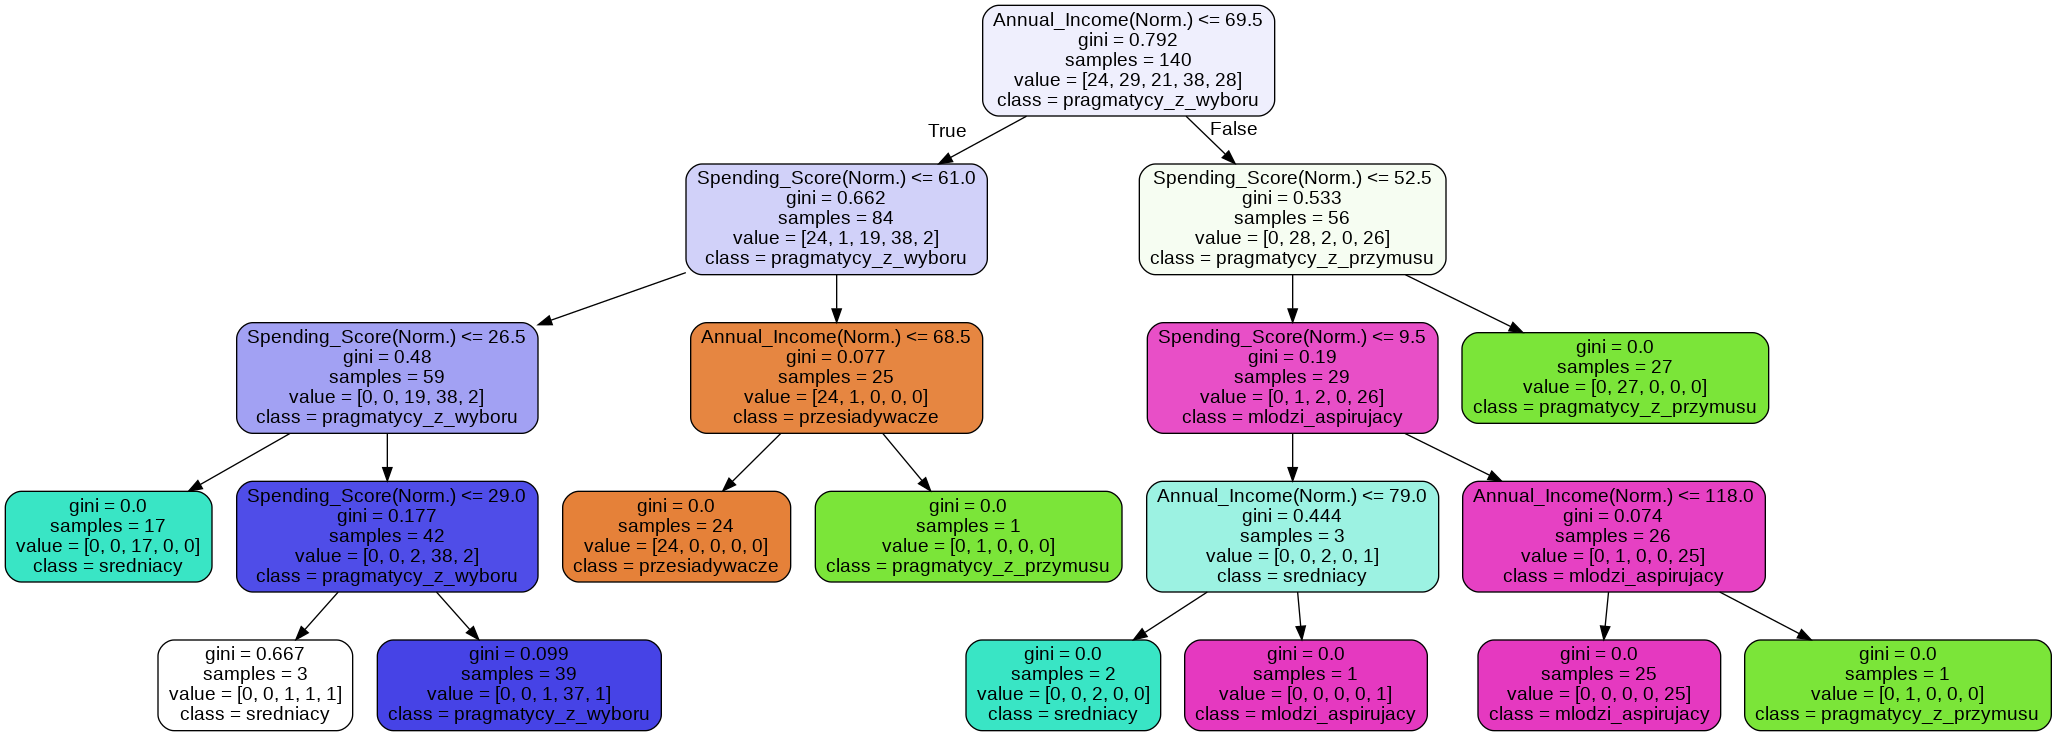

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

random.seed(1)

X = dummy_df_wykres[['Age', 
              'Annual Income (k$)',
              'Spending Score (1-100)']]
y = dummy_df_wykres[['Cluster']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=y)
mytree = DecisionTreeClassifier(criterion='gini',
                                max_depth=4, 
                                random_state=1)
mytree.fit(X_train, 
           y_train)

dot_data = export_graphviz(mytree,
                           filled=True,  
                           rounded=True,
                           class_names=['przesiadywacze', 
                                        'pragmatycy_z_przymusu',  
                                        'sredniacy', 
                                        'pragmatycy_z_wyboru', 
                                        'mlodzi_aspirujacy'],
                           feature_names=['Age(Norm.)',  
                                          'Annual_Income(Norm.)', 
                                          'Spending_Score(Norm.)'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')
Image('tree.png')

#### Model Lasu Losowego:

In [60]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

random.seed(1)

X = dummy_df_wykres[['Age', 
              'Annual Income (k$)',
              'Spending Score (1-100)']]
y = np.ravel(dummy_df_wykres[['Cluster']])

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3) # 70% training and 30% test

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,
        y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test,
                                         y_pred))

Accuracy: 0.9333333333333333


In [0]:
#sprawdzmy czy dobrze sklasyfikuje:
#mloda osoba lat 20, malo zarabiajaca, o wysokim spending score - mlodzi aspirujacy
clf.predict([[20, 15, 90]])

In [0]:
#40 lat, dobre zarobki, malo wydaje - pragmatyk
clf.predict([[40, 100, 10]])